# Task-2: Predictive modeling of customer bookings

This Jupyter notebook includes some code to get you started with this predictive modeling task. We will use various packages for data manipulation, feature engineering and machine learning.



In [1]:
# Importing the libraries and Packages 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *

# Exploratory data analysis

First, we must explore the data in order to better understand what we have and the statistical properties of the dataset.

## 1. Initial Data Inspection


In [2]:
df = pd.read_csv("data/customer_booking.csv", encoding="ISO-8859-1")
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


The `.head()` method allows us to view the first 5 rows in the dataset, this is useful for visual inspection of our columns

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

In [4]:
df.nunique()

num_passengers             9
sales_channel              2
trip_type                  3
purchase_lead            470
length_of_stay           335
flight_hour               24
flight_day                 7
route                    799
booking_origin           104
wants_extra_baggage        2
wants_preferred_seat       2
wants_in_flight_meals      2
flight_duration           21
booking_complete           2
dtype: int64

The `.info()` method gives us a data description, telling us the names of the columns, their data types and how many null values we have. Fortunately, we have no null values. It looks like some of these columns should be converted into different data types, e.g. flight_day.

To provide more context, below is a more detailed data description, explaining exactly what each column means:

- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip Type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking

Before we compute any statistics on the data, lets do any necessary data conversion

In [5]:
df["flight_day"].unique()

array(['Sat', 'Wed', 'Thu', 'Mon', 'Sun', 'Tue', 'Fri'], dtype=object)

In [6]:
mapping = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}

df["flight_day"] = df["flight_day"].map(mapping)

In [7]:
df["flight_day"].unique()

array([6, 3, 4, 1, 7, 2, 5], dtype=int64)

In [8]:
df

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,6,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,6,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,3,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,6,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,3,AKLDEL,India,1,0,1,5.52,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,2,Internet,RoundTrip,27,6,9,6,PERPNH,Australia,1,0,1,5.62,0
49996,1,Internet,RoundTrip,111,6,4,7,PERPNH,Australia,0,0,0,5.62,0
49997,1,Internet,RoundTrip,24,6,22,6,PERPNH,Australia,0,0,1,5.62,0
49998,1,Internet,RoundTrip,15,6,11,1,PERPNH,Australia,1,0,1,5.62,0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  int64  
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(9), object(4)
memory usage: 5.3+ 

In [10]:
conv_features = ['sales_channel','trip_type','route',
                 'booking_origin','wants_extra_baggage',
                 'wants_preferred_seat','wants_in_flight_meals',
                'booking_complete']
def dataconv(df):
    for i in conv_features:
        df[i] = df[i].astype('category')
        
dataconv(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   num_passengers         50000 non-null  int64   
 1   sales_channel          50000 non-null  category
 2   trip_type              50000 non-null  category
 3   purchase_lead          50000 non-null  int64   
 4   length_of_stay         50000 non-null  int64   
 5   flight_hour            50000 non-null  int64   
 6   flight_day             50000 non-null  int64   
 7   route                  50000 non-null  category
 8   booking_origin         50000 non-null  category
 9   wants_extra_baggage    50000 non-null  category
 10  wants_preferred_seat   50000 non-null  category
 11  wants_in_flight_meals  50000 non-null  category
 12  flight_duration        50000 non-null  float64 
 13  booking_complete       50000 non-null  category
dtypes: category(8), float64(1), int64(5)
m

## 2. Summary Statistics

In [11]:
# Summary statistics for numerical columns
df.describe()

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,flight_duration
count,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000
mean,1.591240,84.940480,23.04456,9.06634,3.814420,7.277561
std,1.020165,90.451378,33.88767,5.41266,1.992792,1.496863
min,1.000000,0.000000,0.00000,0.00000,1.000000,4.670000
25%,1.000000,21.000000,5.00000,5.00000,2.000000,5.620000
50%,1.000000,51.000000,17.00000,9.00000,4.000000,7.570000
75%,2.000000,115.000000,28.00000,13.00000,5.000000,8.830000
max,9.000000,867.000000,778.00000,23.00000,7.000000,9.500000


The `.describe()` method gives us a summary of descriptive statistics over the entire dataset (only works for numeric columns). This gives us a quick overview of a few things such as the mean, min, max and overall distribution of each column.

From this point, you should continue exploring the dataset with some visualisations and other metrics that you think may be useful. Then, you should prepare your dataset for predictive modelling. Finally, you should train your machine learning model, evaluate it with performance metrics and output visualisations for the contributing variables. All of this analysis should be summarised in your single slide.

In [12]:
# Count of distinct elements in each columns
df.nunique()

num_passengers             9
sales_channel              2
trip_type                  3
purchase_lead            470
length_of_stay           335
flight_hour               24
flight_day                 7
route                    799
booking_origin           104
wants_extra_baggage        2
wants_preferred_seat       2
wants_in_flight_meals      2
flight_duration           21
booking_complete           2
dtype: int64

## 3. Distribution of Features

### a. Numerical Features

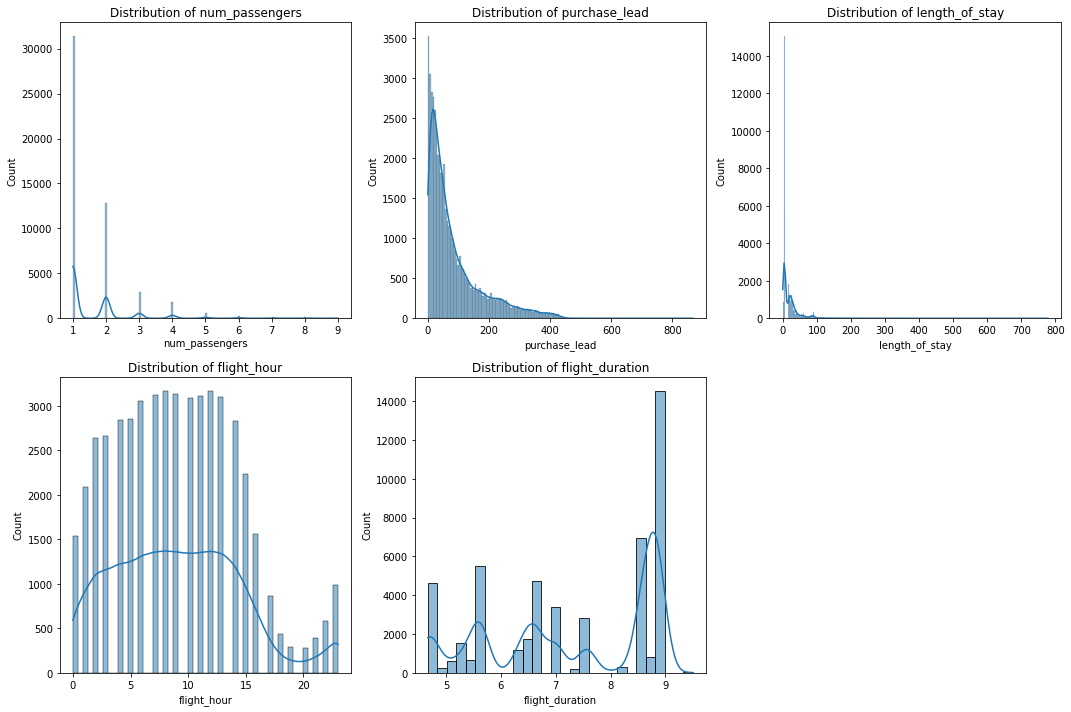

In [13]:
numerical_cols = ['num_passengers',
                  'purchase_lead',
                  'length_of_stay',
                  'flight_hour',
                  'flight_duration']

plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

### b. Categorical Features

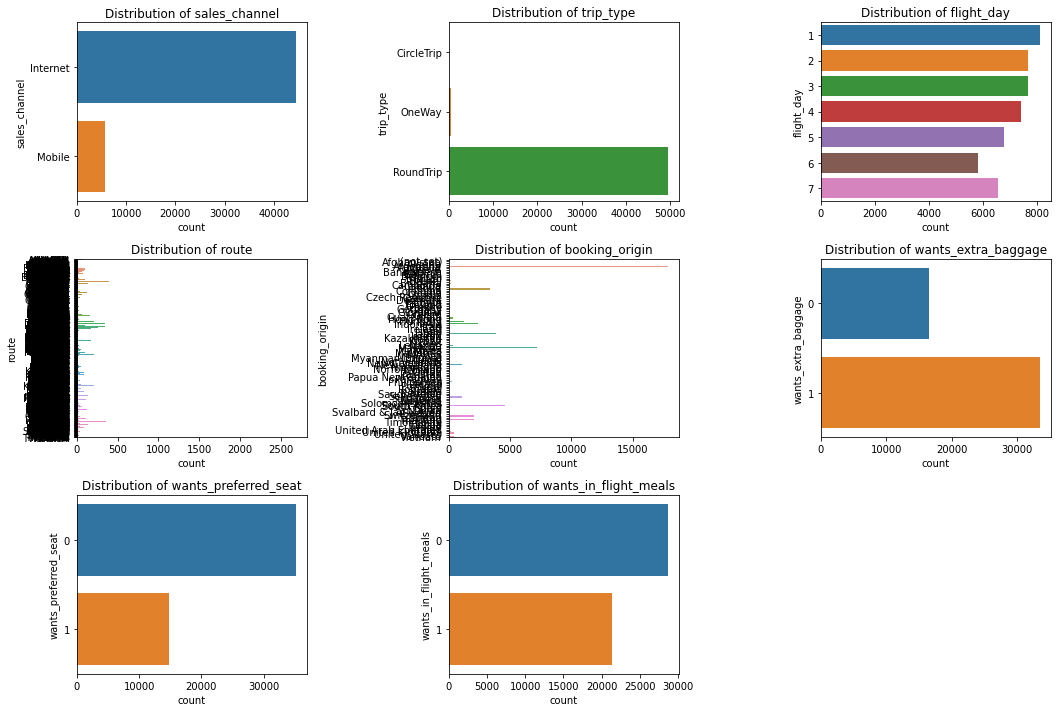

In [14]:
categorical_cols = ['sales_channel',
                    'trip_type',
                    'flight_day',
                    'route',
                    'booking_origin',
                    'wants_extra_baggage',
                    'wants_preferred_seat',
                    'wants_in_flight_meals']

# Plot distributions for categorical features
plt.figure(figsize=(15, 10))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(3, 3, i)
    sns.countplot(y=df[col])
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

## 4. Correlation Analysis - Numerical Cols

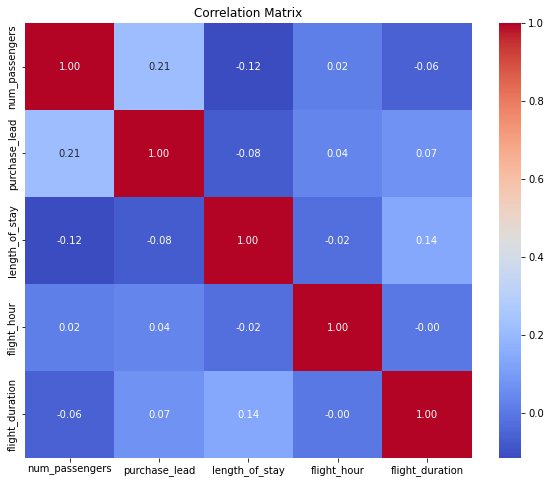

In [15]:
# Compute the correlation matrix
corr_matrix = df[numerical_cols].corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

## 5. Missing Values

In [16]:
missing_values = df.isnull().sum()
print('Missing Values in Each Column:')
print(missing_values)

Missing Values in Each Column:
num_passengers           0
sales_channel            0
trip_type                0
purchase_lead            0
length_of_stay           0
flight_hour              0
flight_day               0
route                    0
booking_origin           0
wants_extra_baggage      0
wants_preferred_seat     0
wants_in_flight_meals    0
flight_duration          0
booking_complete         0
dtype: int64


## 6. Target Variable Analysis

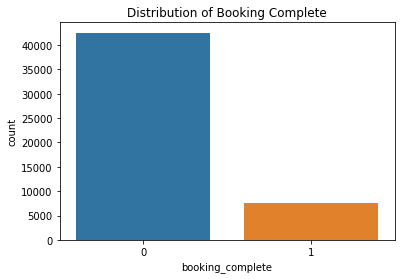


Booking Complete value counts:
0    0.85044
1    0.14956
Name: booking_complete, dtype: float64


In [17]:
# Distribution of the target variable
plt.figure(figsize=(6, 4))
sns.countplot(x=df['booking_complete'])
plt.title('Distribution of Booking Complete')
plt.show()

# Display value counts and proportions
print('\nBooking Complete value counts:')
print(df['booking_complete'].value_counts(normalize=True))

## 7. Feature Relationships

### a. Numerical Features

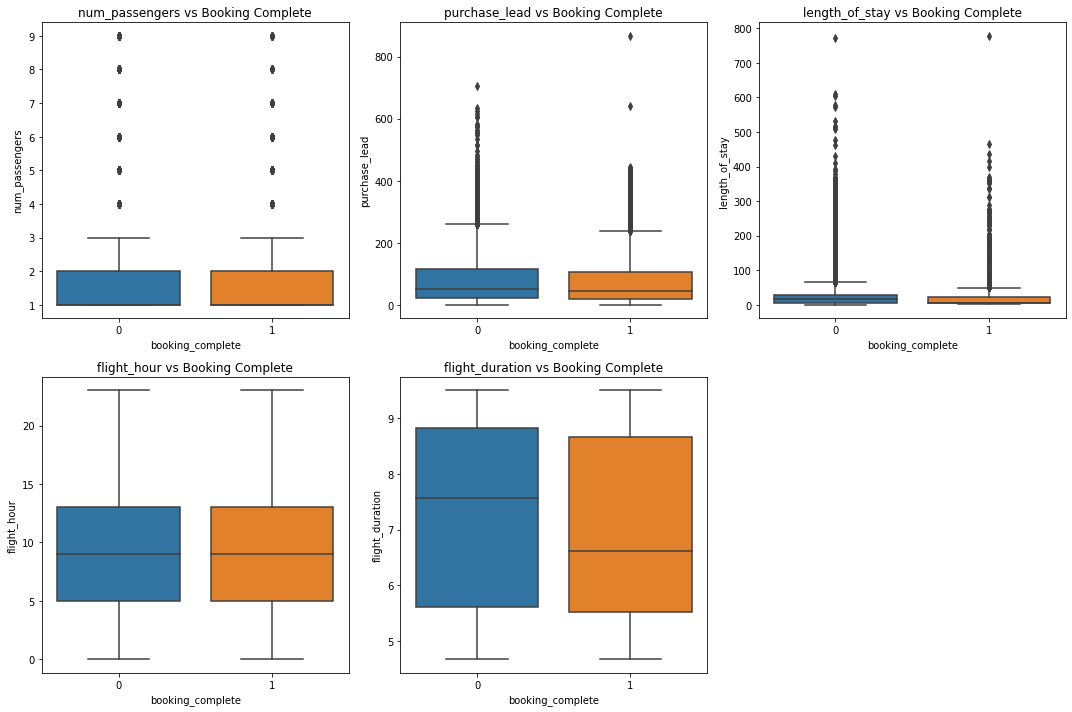

In [18]:
# Relationship between numerical features and the target variable
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x=df['booking_complete'], y=df[col])
    plt.title(f'{col} vs Booking Complete')
plt.tight_layout()
plt.show()

### b. Handling Outliers

In [19]:
# Define a new IQR multiplier
iqr_multiplier = 1

# Function to remove outliers using IQR method
def remove_outliers_iqr(df, numerical_cols, iqr_multiplier):
    Q1 = df[numerical_cols].quantile(0.25)
    Q3 = df[numerical_cols].quantile(0.75)
    IQR = Q3 - Q1
    is_outlier = (df[numerical_cols] < (Q1 - iqr_multiplier * IQR)) | (df[numerical_cols] > (Q3 + iqr_multiplier * IQR))
    return df[~is_outlier.any(axis=1)]

# Remove outliers
df_cleaned = remove_outliers_iqr(df, numerical_cols, iqr_multiplier)

In [20]:
df_cleaned

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
1,1,Internet,RoundTrip,112,20,3,6,AKLDEL,New Zealand,0,0,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,6,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,3,AKLDEL,India,1,0,1,5.52,0
5,1,Internet,RoundTrip,3,48,20,4,AKLDEL,New Zealand,1,0,1,5.52,0
6,3,Internet,RoundTrip,201,33,6,4,AKLDEL,New Zealand,1,0,1,5.52,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49994,2,Internet,RoundTrip,25,6,9,7,PERPNH,Australia,0,0,0,5.62,0
49995,2,Internet,RoundTrip,27,6,9,6,PERPNH,Australia,1,0,1,5.62,0
49996,1,Internet,RoundTrip,111,6,4,7,PERPNH,Australia,0,0,0,5.62,0
49998,1,Internet,RoundTrip,15,6,11,1,PERPNH,Australia,1,0,1,5.62,0


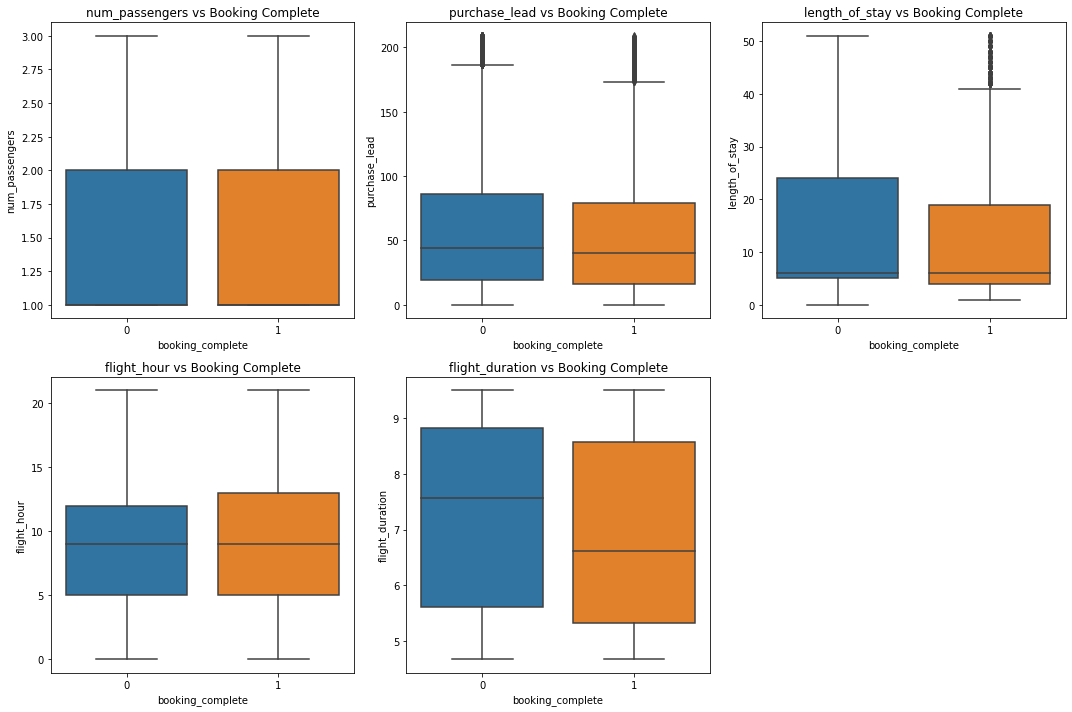

In [21]:
# Relationship between numerical features and the target variable
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x=df_cleaned['booking_complete'], y=df_cleaned[col])
    plt.title(f'{col} vs Booking Complete')
plt.tight_layout()
plt.show()

### b. Categorical Features

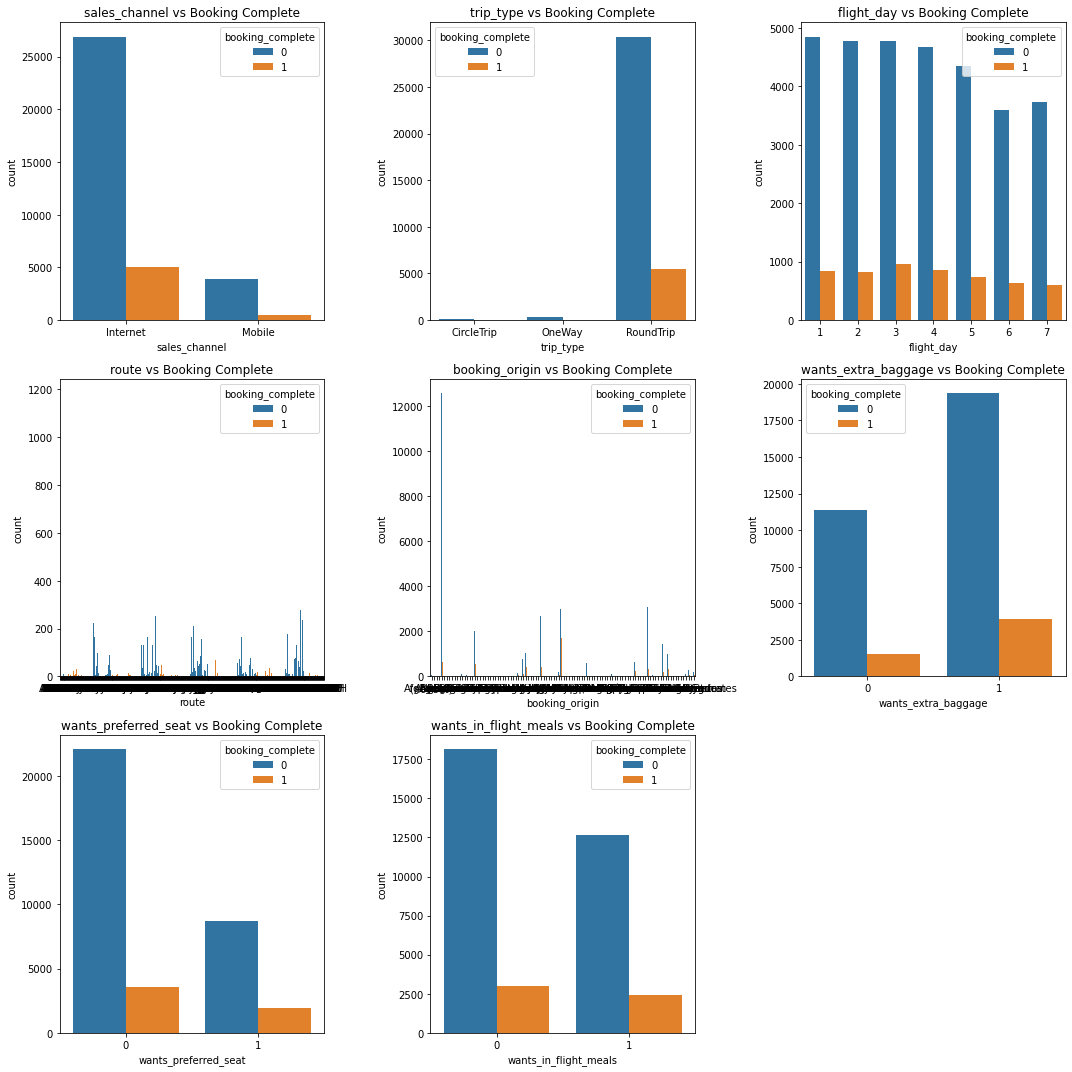

In [22]:
# Relationship between categorical features and the target variable
plt.figure(figsize=(15, 15))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(3, 3, i)
    sns.countplot(x=df_cleaned[col], hue=df_cleaned['booking_complete'])
    plt.title(f'{col} vs Booking Complete')
plt.tight_layout()
plt.show()

# Model Training

## Feature Engineering

In [23]:
df_cleaned

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
1,1,Internet,RoundTrip,112,20,3,6,AKLDEL,New Zealand,0,0,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,6,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,3,AKLDEL,India,1,0,1,5.52,0
5,1,Internet,RoundTrip,3,48,20,4,AKLDEL,New Zealand,1,0,1,5.52,0
6,3,Internet,RoundTrip,201,33,6,4,AKLDEL,New Zealand,1,0,1,5.52,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49994,2,Internet,RoundTrip,25,6,9,7,PERPNH,Australia,0,0,0,5.62,0
49995,2,Internet,RoundTrip,27,6,9,6,PERPNH,Australia,1,0,1,5.62,0
49996,1,Internet,RoundTrip,111,6,4,7,PERPNH,Australia,0,0,0,5.62,0
49998,1,Internet,RoundTrip,15,6,11,1,PERPNH,Australia,1,0,1,5.62,0


In [24]:
df_cleaned[['sales_channel','route','trip_type','booking_origin']].nunique()

sales_channel       2
route             778
trip_type           3
booking_origin     99
dtype: int64

In [25]:
# feature engineering for column 'sales_channel' 

print('Number of unique categories in sales_channel:',df_cleaned['sales_channel'].nunique())
df_cleaned = pd.get_dummies(df_cleaned,columns=['sales_channel'])
df_cleaned

Number of unique categories in sales_channel: 2


,num_passengers,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete,sales_channel_Internet,sales_channel_Mobile
1,1,RoundTrip,112,20,3,6,AKLDEL,New Zealand,0,0,0,5.52,0,1,0
3,1,RoundTrip,96,31,4,6,AKLDEL,New Zealand,0,0,1,5.52,0,1,0
4,2,RoundTrip,68,22,15,3,AKLDEL,India,1,0,1,5.52,0,1,0
5,1,RoundTrip,3,48,20,4,AKLDEL,New Zealand,1,0,1,5.52,0,1,0
6,3,RoundTrip,201,33,6,4,AKLDEL,New Zealand,1,0,1,5.52,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49994,2,RoundTrip,25,6,9,7,PERPNH,Australia,0,0,0,5.62,0,1,0
49995,2,RoundTrip,27,6,9,6,PERPNH,Australia,1,0,1,5.62,0,1,0
49996,1,RoundTrip,111,6,4,7,PERPNH,Australia,0,0,0,5.62,0,1,0
49998,1,RoundTrip,15,6,11,1,PERPNH,Australia,1,0,1,5.62,0,1,0


In [26]:
# feature engineering for column 'trip_type' 

print('Number of unique categories in trip_type:',df_cleaned['trip_type'].nunique())
df_cleaned = pd.get_dummies(df_cleaned,columns=['trip_type'])
df_cleaned

Number of unique categories in trip_type: 3


,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete,sales_channel_Internet,sales_channel_Mobile,trip_type_CircleTrip,trip_type_OneWay,trip_type_RoundTrip
1,1,112,20,3,6,AKLDEL,New Zealand,0,0,0,5.52,0,1,0,0,0,1
3,1,96,31,4,6,AKLDEL,New Zealand,0,0,1,5.52,0,1,0,0,0,1
4,2,68,22,15,3,AKLDEL,India,1,0,1,5.52,0,1,0,0,0,1
5,1,3,48,20,4,AKLDEL,New Zealand,1,0,1,5.52,0,1,0,0,0,1
6,3,201,33,6,4,AKLDEL,New Zealand,1,0,1,5.52,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49994,2,25,6,9,7,PERPNH,Australia,0,0,0,5.62,0,1,0,0,0,1
49995,2,27,6,9,6,PERPNH,Australia,1,0,1,5.62,0,1,0,0,0,1
49996,1,111,6,4,7,PERPNH,Australia,0,0,0,5.62,0,1,0,0,0,1
49998,1,15,6,11,1,PERPNH,Australia,1,0,1,5.62,0,1,0,0,0,1


In [27]:
# Set display options
pd.set_option('display.max_rows', None)  # Show all rows

In [28]:
# feature engineering for 'route'
df_cleaned['route'].value_counts()

AKLKUL    1550
PENTPE     746
ICNSIN     662
MELSGN     614
DMKPER     545
DPSICN     536
ICNSYD     533
DMKKIX     501
MELTPE     491
DMKOOL     477
MELPEN     446
SGNSYD     430
DMKSYD     384
CMBMEL     343
COKSYD     329
HNDPEN     320
DPSPVG     319
COKMEL     306
PENPER     304
PERSGN     300
HKTICN     295
HKTSYD     280
HKTPER     275
DMKMEL     275
CGKICN     274
KTMMFM     265
PENSYD     262
HNDSIN     257
DPSKIX     255
ICNPER     255
COKPER     249
CGKHND     243
PERTPE     242
DPSHND     241
DMKICN     239
CMBSYD     237
ICNPEN     236
ICNMEL     228
CGKKIX     222
KIXSIN     218
DPSPEK     212
PENPVG     204
OOLSGN     200
CTSDMK     196
HKTOOL     195
HYDSYD     193
HKTKIX     185
KCHPER     182
PERPNH     177
DPSPUS     175
HNDPER     173
JHBKTM     172
DELMEL     170
KNOTPE     168
KIXPEN     162
SYDTPE     161
BKIICN     160
HKTMEL     159
ICNOOL     159
KCHMEL     152
MELMNL     149
HKTPEK     143
DMKHND     136
DACSYD     134
DELDPS     133
HKGPER     132
PEKPEN    

In [29]:
print('Number of unique categories in route:',df_cleaned['route'].nunique())

threshold = 100

# Find categories with counts below the threshold
counts = df_cleaned['route'].value_counts()
to_remove = counts[counts < threshold].index

# Replace categories below the threshold with 'Other' 
df_cleaned['route'] = df_cleaned['route'].apply(lambda x: x if x not in to_remove else 'other')

print('New number of unique categories in route:',df_cleaned['route'].nunique())

df_cleaned = pd.get_dummies(df_cleaned,columns=['route'])

Number of unique categories in route: 778
New number of unique categories in route: 90


In [30]:
df_cleaned['booking_origin'].value_counts()

Australia               13220
Malaysia                 4687
South Korea              3442
Japan                    3071
China                    2549
Taiwan                   1639
Indonesia                1467
Thailand                 1311
India                     873
Singapore                 866
New Zealand               630
United States             365
Macau                     284
Vietnam                   270
Hong Kong                 220
Philippines               158
Brunei                    126
United Kingdom            125
Cambodia                  106
(not set)                  63
Sri Lanka                  60
France                     49
Canada                     45
Myanmar (Burma)            39
Italy                      39
Germany                    35
Netherlands                35
Mauritius                  34
United Arab Emirates       34
Nepal                      33
Bangladesh                 26
Russia                     25
Spain                      24
Saudi Arab

In [31]:
pd.reset_option('display.max_rows')

In [32]:
# feature engineering for 'booking_origin' 

print('Number of unique categories in booking_origin:',df_cleaned['booking_origin'].nunique())

threshold = 100

counts = df_cleaned['booking_origin'].value_counts()
to_remove = counts[counts < threshold].index

df_cleaned['booking_origin'] = df_cleaned['booking_origin'].apply(lambda x: x if x not in to_remove else 'other')

print('New number of unique categories in booking_origin:',df_cleaned['booking_origin'].nunique())

df_cleaned = pd.get_dummies(df_cleaned,columns=['booking_origin'])

Number of unique categories in booking_origin: 99
New number of unique categories in booking_origin: 20


In [33]:
df_cleaned

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete,...,booking_origin_New Zealand,booking_origin_Philippines,booking_origin_Singapore,booking_origin_South Korea,booking_origin_Taiwan,booking_origin_Thailand,booking_origin_United Kingdom,booking_origin_United States,booking_origin_Vietnam,booking_origin_other
1,1,112,20,3,6,0,0,0,5.52,0,...,1,0,0,0,0,0,0,0,0,0
3,1,96,31,4,6,0,0,1,5.52,0,...,1,0,0,0,0,0,0,0,0,0
4,2,68,22,15,3,1,0,1,5.52,0,...,0,0,0,0,0,0,0,0,0,0
5,1,3,48,20,4,1,0,1,5.52,0,...,1,0,0,0,0,0,0,0,0,0
6,3,201,33,6,4,1,0,1,5.52,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49994,2,25,6,9,7,0,0,0,5.62,0,...,0,0,0,0,0,0,0,0,0,0
49995,2,27,6,9,6,1,0,1,5.62,0,...,0,0,0,0,0,0,0,0,0,0
49996,1,111,6,4,7,0,0,0,5.62,0,...,0,0,0,0,0,0,0,0,0,0
49998,1,15,6,11,1,1,0,1,5.62,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
# Taking care of dummy variable trap
df_cleaned.drop(columns=['booking_origin_other','route_other'], inplace=True)
df_cleaned

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete,...,booking_origin_Malaysia,booking_origin_New Zealand,booking_origin_Philippines,booking_origin_Singapore,booking_origin_South Korea,booking_origin_Taiwan,booking_origin_Thailand,booking_origin_United Kingdom,booking_origin_United States,booking_origin_Vietnam
1,1,112,20,3,6,0,0,0,5.52,0,...,0,1,0,0,0,0,0,0,0,0
3,1,96,31,4,6,0,0,1,5.52,0,...,0,1,0,0,0,0,0,0,0,0
4,2,68,22,15,3,1,0,1,5.52,0,...,0,0,0,0,0,0,0,0,0,0
5,1,3,48,20,4,1,0,1,5.52,0,...,0,1,0,0,0,0,0,0,0,0
6,3,201,33,6,4,1,0,1,5.52,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49994,2,25,6,9,7,0,0,0,5.62,0,...,0,0,0,0,0,0,0,0,0,0
49995,2,27,6,9,6,1,0,1,5.62,0,...,0,0,0,0,0,0,0,0,0,0
49996,1,111,6,4,7,0,0,0,5.62,0,...,0,0,0,0,0,0,0,0,0,0
49998,1,15,6,11,1,1,0,1,5.62,0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
# split the data into train and test
X = df_cleaned.drop(columns=['booking_complete'], axis=1)
y = df_cleaned['booking_complete']

X_train,X_test,y_train,y_test = train_test_split(X,
                                                 y,
                                                 test_size=0.2,
                                                 random_state=42)

# Print shapes of the datasets
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (28980, 122)
Shape of X_test: (7245, 122)
Shape of y_train: (28980,)
Shape of y_test: (7245,)


In [36]:
X_train

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,sales_channel_Internet,...,booking_origin_Malaysia,booking_origin_New Zealand,booking_origin_Philippines,booking_origin_Singapore,booking_origin_South Korea,booking_origin_Taiwan,booking_origin_Thailand,booking_origin_United Kingdom,booking_origin_United States,booking_origin_Vietnam
34150,1,1,4,13,2,1,0,0,5.62,1,...,0,0,0,0,0,0,0,0,0,0
48992,1,27,6,4,6,0,0,0,8.83,1,...,0,0,0,0,0,0,0,0,0,0
38547,3,27,5,6,6,1,1,0,8.58,1,...,0,0,0,0,0,0,0,0,0,0
24520,1,8,35,18,1,1,0,1,8.58,0,...,0,0,0,0,0,0,0,0,1,0
17721,1,8,21,4,7,1,0,0,4.75,1,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25496,1,71,39,5,3,1,0,0,8.58,1,...,0,0,0,0,0,0,0,0,0,0
9851,2,203,18,2,2,1,1,0,5.62,1,...,0,0,0,0,0,0,1,0,0,0
17213,1,117,36,6,2,1,0,0,4.67,1,...,0,0,0,0,0,1,0,0,0,0
1623,1,11,32,12,5,0,0,0,8.83,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
X_test

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,sales_channel_Internet,...,booking_origin_Malaysia,booking_origin_New Zealand,booking_origin_Philippines,booking_origin_Singapore,booking_origin_South Korea,booking_origin_Taiwan,booking_origin_Thailand,booking_origin_United Kingdom,booking_origin_United States,booking_origin_Vietnam
37921,2,162,5,7,4,0,1,0,4.67,1,...,0,0,0,0,0,1,0,0,0,0
5358,1,42,25,1,7,1,0,1,8.58,1,...,0,0,0,0,0,0,0,0,0,0
10845,1,79,18,1,3,1,1,0,8.83,1,...,0,0,0,0,0,0,0,0,0,0
27698,1,36,3,12,3,1,0,0,8.58,1,...,0,0,0,0,0,0,0,0,0,0
9662,1,30,49,9,6,1,1,1,8.83,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3375,1,2,17,13,1,1,0,0,5.62,1,...,0,0,0,0,0,0,0,0,0,0
11146,1,31,24,0,5,1,0,1,5.62,1,...,0,0,0,0,0,0,0,0,0,0
43609,1,10,6,15,1,0,0,0,5.33,1,...,0,0,0,0,0,0,0,0,0,0
43675,1,4,6,0,6,0,1,0,5.62,1,...,0,0,0,0,0,0,0,0,0,0


In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *

In [39]:
models = {
    "Logistic Regression":LogisticRegression(),
    "Decision Tree":DecisionTreeClassifier(),
    "Random Forest":RandomForestClassifier(),
}
for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train,y_train) # Training Model
    
    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Training set performance
    model_training_accuracy = accuracy_score(y_train, y_train_pred)
    model_train_f1_score = f1_score(y_train,y_train_pred, average='weighted')
    model_train_recall = recall_score(y_train,y_train_pred)
    model_train_precision = precision_score(y_train,y_train_pred)
    model_train_roc_auc_score = roc_auc_score(y_train,y_train_pred)
    
    # Testing set performance
    model_testing_accuracy = accuracy_score(y_test, y_test_pred)
    model_test_f1_score = f1_score(y_test,y_test_pred, average='weighted')
    model_test_recall = recall_score(y_test,y_test_pred)
    model_test_precision = precision_score(y_test,y_test_pred)
    model_test_roc_auc_score = roc_auc_score(y_test,y_test_pred)
    
    print(list(models.keys())[i])
    
    print("Model Performance for Training Set")
    print("- Accuracy: {:.4f}".format(model_training_accuracy))
    print("- F1 Score: {:.4f}".format(model_train_f1_score))
    print("- Recall: {:.4f}".format(model_train_recall))
    print("- Precision: {:.4f}".format(model_train_precision))
    print("- AUC ROC Score: {:.4f}".format(model_train_roc_auc_score))
    
    print('-'*40)
    
    print("Model Performance for Testing Set")
    print("- Accuracy: {:.4f}".format(model_testing_accuracy))
    print("- F1 Score: {:.4f}".format(model_test_f1_score))
    print("- Recall: {:.4f}".format(model_test_recall))
    print("- Precision: {:.4f}".format(model_test_precision))
    print("- AUC ROC Score: {:.4f}".format(model_test_roc_auc_score))
    
    print('='*40)
    print('\n')

F:\Anaconda_Data\envs\Georgian\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression
Model Performance for Training Set
- Accuracy: 0.8489
- F1 Score: 0.7928
- Recall: 0.0521
- Precision: 0.5169
- AUC ROC Score: 0.5217
----------------------------------------
Model Performance for Testing Set
- Accuracy: 0.8511
- F1 Score: 0.7966
- Recall: 0.0513
- Precision: 0.4701
- AUC ROC Score: 0.5206


Decision Tree
Model Performance for Training Set
- Accuracy: 0.9999
- F1 Score: 0.9999
- Recall: 0.9991
- Precision: 1.0000
- AUC ROC Score: 0.9995
----------------------------------------
Model Performance for Testing Set
- Accuracy: 0.7805
- F1 Score: 0.7845
- Recall: 0.3041
- Precision: 0.2786
- AUC ROC Score: 0.5837


Random Forest
Model Performance for Training Set
- Accuracy: 0.9998
- F1 Score: 0.9998
- Recall: 0.9986
- Precision: 0.9998
- AUC ROC Score: 0.9993
----------------------------------------
Model Performance for Testing Set
- Accuracy: 0.8490
- F1 Score: 0.8080
- Recall: 0.1129
- Precision: 0.4583
- AUC ROC Score: 0.5449




In [40]:
models ={
    "Random Forest Fine-Tuned":RandomForestClassifier(n_estimators=300,
                                           min_samples_split=5,
                                           max_features='sqrt',
                                           max_depth=None)
}

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train,y_train) # Training Model
    
    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Training set performance
    model_training_accuracy = accuracy_score(y_train, y_train_pred)
    model_train_f1_score = f1_score(y_train,y_train_pred, average='weighted')
    model_train_recall = recall_score(y_train,y_train_pred)
    model_train_precision = precision_score(y_train,y_train_pred)
    model_train_roc_auc_score = roc_auc_score(y_train,y_train_pred)
    
    # Testing set performance
    model_testing_accuracy = accuracy_score(y_test, y_test_pred)
    model_test_f1_score = f1_score(y_test,y_test_pred, average='weighted')
    model_test_recall = recall_score(y_test,y_test_pred)
    model_test_precision = precision_score(y_test,y_test_pred)
    model_test_roc_auc_score = roc_auc_score(y_test,y_test_pred)
    
    print(list(models.keys())[i])
    
    print("Model Performance for Training Set")
    print("- Accuracy: {:.4f}".format(model_training_accuracy))
    print("- F1 Score: {:.4f}".format(model_train_f1_score))
    print("- Recall: {:.4f}".format(model_train_recall))
    print("- Precision: {:.4f}".format(model_train_precision))
    print("- AUC ROC Score: {:.4f}".format(model_train_roc_auc_score))
    
    print('-'*40)
    
    print("Model Performance for Testing Set")
    print("- Accuracy: {:.4f}".format(model_testing_accuracy))
    print("- F1 Score: {:.4f}".format(model_test_f1_score))
    print("- Recall: {:.4f}".format(model_test_recall))
    print("- Precision: {:.4f}".format(model_test_precision))
    print("- AUC ROC Score: {:.4f}".format(model_test_roc_auc_score))
    
    print('='*40)
    print('\n')

Random Forest Fine-Tuned
Model Performance for Training Set
- Accuracy: 0.9518
- F1 Score: 0.9479
- Recall: 0.6835
- Precision: 0.9980
- AUC ROC Score: 0.8416
----------------------------------------
Model Performance for Testing Set
- Accuracy: 0.8519
- F1 Score: 0.8076
- Recall: 0.1007
- Precision: 0.4977
- AUC ROC Score: 0.5415




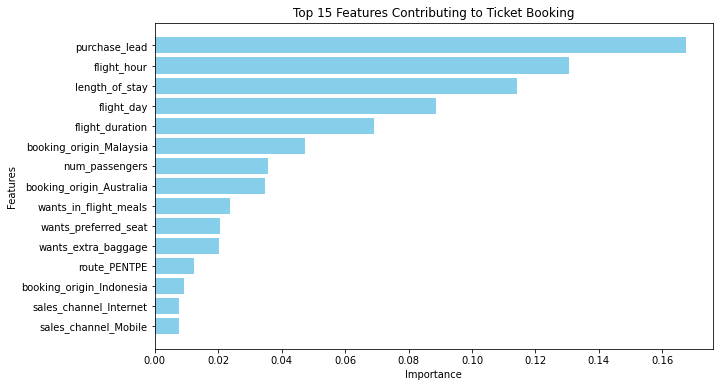

In [41]:
# view the top 15 feature importance


importances = model.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for feature importances
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Select the top 15 features
top_15_importance_df = importance_df.head(15)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(top_15_importance_df['Feature'], top_15_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Top 15 Features Contributing to Ticket Booking')
plt.gca().invert_yaxis()  # To have the highest importance at the top
plt.show()